In [1]:
import os
import numpy as np
import matplotlib
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from __future__ import division
%matplotlib inline

In [8]:
HJA_path = 'G:/projects/EWEB_2015/Data/Work/carbon/HJA' # forward slashes to avoid \ interpreted as escape character
HJA_file = 'HJA_composite_5m.tif'
EWEB_path = 'G:/projects/EWEB_2015/Analysis/Scratch/JET_modeloutputs/Carbon' # forward slashes to avoid \ interpreted as escape character
EWEB_file = 'pwpnfmsk.tif'
EWEB_ALC_path = 'G:/projects/EWEB_2015/Data/Work/carbon/EWEB' # forward slashes to avoid \ interpreted as escape character
EWEB_ALC_file = 'EWEB_carbon_storage.tif'

In [9]:
# read in the HJA raster

# The raster read command is currently configured to take in a composite raster where HT95 is the first band
# and Index3 is the second band
with rasterio.open(os.path.join(HJA_path, HJA_file)) as src:
    HJA_HT = src.read(1, masked=True)
    HJA_index = src.read(2, masked=True)

In [10]:
# read in the EWEB raster

# This raster should have non-forest areas masked out using whatever No Data value is assigned.
# The raster read command is currently configured to take in a composite raster where HT95 is the first band
# and Index3 is the second band
with rasterio.open(os.path.join(EWEB_path, EWEB_file)) as src:
    EWEB_HT = src.read(1, masked=True)
    EWEB_index = src.read(2, masked=True)
    profile = src.profile
    mask = src.read_masks()

In [11]:
# inspect the shape (dimensions) of the images
print('HJA image shape: ', HJA_HT.shape)
print('EWEB image shape: ', EWEB_HT.shape)

HJA image shape:  (2156L, 2874L)
EWEB image shape:  (2996L, 14920L)


In [12]:
# take a look at some descriptive statistics for these rasters
for raster in ['HJA_index', 'EWEB_index', 'HJA_HT', 'EWEB_HT']:
    name = raster
    raster = eval(name)
    stats = []
    stats.append({
        'min': raster.min(),
        'mean': raster.mean(),
        'median': np.median(raster),
        'max': raster.max()})
    print(name, stats, sep =':')

HJA_index:[{'max': 208000.0, 'mean': 29048.588002094344, 'median': masked, 'min': 1.0}]
EWEB_index:[{'max': 208000.0, 'mean': 12958.461972389294, 'median': masked, 'min': 0.0}]
HJA_HT:[{'max': 195.747802734375, 'mean': 31.230723862729484, 'median': masked, 'min': 1.0127999782562256}]
EWEB_HT:[{'max': 208.70552, 'mean': 69.569675985041499, 'median': masked, 'min': 2.0378301}]


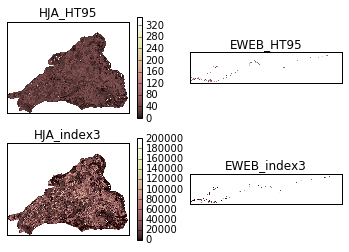

In [13]:
# display raster images of the index3 values for EWEB and HJA
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# visualize the first row rasters (HT95) as images
HJAHT = ax1.imshow(HJA_HT, cmap='pink', vmin=0, vmax=350)
ax2.imshow(EWEB_HT, cmap='pink', vmin=0, vmax=350)
# add titles
ax1.set_title('HJA_HT95')
ax2.set_title('EWEB_HT95')
# add a color bar
cbar1 = f.colorbar(HJAHT, ax = ax1)

# visualize the second row of rasters (Index3) as images
HJAIDX = ax3.imshow(HJA_index, cmap = 'pink', vmin=0, vmax=200000)
ax4.imshow(EWEB_index, cmap='pink', vmin=0, vmax=200000)
# add titles
ax3.set_title('HJA_index3')
ax4.set_title('EWEB_index3')
# add a colorbar
cbar2 = f.colorbar(HJAIDX, ax = ax3)

# remove axis marks and labels
for ax in [ax1, ax2, ax3, ax4]:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [14]:
# flatten the arrays for regression
HJA_HT_flat = HJA_HT.flatten()
HJA_index_flat = HJA_index.flatten()
EWEB_HT_flat = EWEB_HT.flatten()
EWEB_index_flat = EWEB_index.flatten()

In [16]:
# fit regressions to the flattened arrays
# quadratic regressions
# index3 is square-root transformed for linearity
HJA_quad_coefs = np.ma.polyfit(HJA_HT_flat, np.sqrt(HJA_index_flat), 1) # make sure you're using polyfit for masked array! (np.ma.polyfit)
EWEB_quad_coefs = np.ma.polyfit(EWEB_HT_flat, np.sqrt(EWEB_index_flat), 1)

# create polynomials for function coefficients in case you want to call
# the functions later (e.g., for graphing best-fit lines)
HJA_quad = np.poly1d(HJA_quad_coefs)
EWEB_quad = np.poly1d(EWEB_quad_coefs)
print('HJA_quad_coefs: ',HJA_quad_coefs)
print('EWEB_quad_coefs: ',EWEB_quad_coefs)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


HJA_quad_coefs:  [  4.34984713  10.96894163]
EWEB_quad_coefs:  [  1.56009614 -13.32955132]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


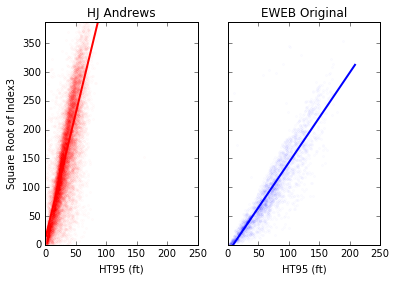

In [17]:
# Graph INDEX3 by HT95 before any transformations

# sample from arrays for plotting to mitigate long load times in matplotlib
sample = 150 # subsample every X points for graphing from each of the datasets
HJA_x = HJA_HT_flat[0::sample]
HJA_y = np.sqrt(HJA_index_flat[0::sample])
EWEB_x = EWEB_HT_flat[0::sample]
EWEB_y = np.sqrt(EWEB_index_flat[0::sample])

# arguments for scatter plots, will be unpacked when scatterplot method called
HJA_args = [HJA_x, HJA_y]
EWEB_args = [EWEB_x, EWEB_y]

f, ([HJA, EWEB]) = plt.subplots(1, 2, sharex=True, sharey=True) # a single row of two plots

# to plot regression lines, use an array of x values spanning min-max of heights in EWEB and HJA datasets 
xp = np.linspace(min(np.amin(HJA_HT_flat),np.amin(EWEB_HT_flat)),max(np.amax(HJA_HT_flat),np.amax(EWEB_HT_flat)))

# arguments for regression line plots
HJA_regline = [xp, HJA_quad(xp)]
EWEB_regline = [xp, EWEB_quad(xp)]

# plot scatters
HJA.scatter(*HJA_args, color='red', alpha=0.01, marker='.')
EWEB.scatter(*EWEB_args, color='blue', alpha=0.01, marker ='.')

# plot regression lines
HJA.plot(*HJA_regline, color='red', linewidth=2)
EWEB.plot(*EWEB_regline, color='blue', linewidth=2)

for ax in [EWEB, HJA]: # set axis limits for all plots, label x for all plots
    ax.set_ylim(bottom=0, top=np.sqrt(208000))
    ax.set_xlim(0, 250)
    ax.set_xlabel('HT95 (ft)')

HJA.set_title('HJ Andrews')
HJA.set_ylabel('Square Root of Index3')
EWEB.set_title('EWEB Original')
    
plt.show()

In [18]:
# transform EWEB index estimates to HJA index estimates

# Quadratic transform
def quad_transform(y):
    coefs = EWEB_quad_coefs.copy()
    # subtract y from last coefficient such that the equation is equal to zero, 
    # for solving using np.roots function
    coefs[-1] -= y 
    
    # solve for the implied value of x (HT95) given the value of y (index3)
    imp_x = np.roots(coefs)[0] 
    
    # solve for the transformed value of y (new_index3) given the implied value of x (HT95)
    trans_y = np.polyval(HJA_quad_coefs, imp_x) 
    
    return trans_y

# vectorize the quadratic transformation function so it can be applied element-wise to an array
vec_quad_transform = np.vectorize(quad_transform, otypes=[np.float])

# calculate the new Index3 value for EWEB
EWEB_new_index = vec_quad_transform(np.sqrt(EWEB_index))**2

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in sqrt


In [19]:
# calculate aboveground live carbon using equation from Zald et al.
HJA_ALC = (1.2496240 + 0.0219194*HJA_HT - 0.0000049*HJA_index)**3
EWEB_ALC = (1.2496240 + 0.0219194*EWEB_HT - 0.0000049*EWEB_new_index)**3

In [20]:
for raster in ['HJA_index', 'EWEB_new_index', 'HJA_HT', 'EWEB_HT', 'HJA_ALC', 'EWEB_ALC']:
    name = raster
    raster = eval(name)
    stats = []
    stats.append({
        'min': raster.min(),
        'mean': raster.mean(),
        'median': np.median(raster),
        'max': raster.max()})
    print(name, stats, sep =':')

HJA_index:[{'max': 208000.0, 'mean': 29048.588002094344, 'median': masked, 'min': 1.0}]
EWEB_new_index:[{'max': 1741727.7308858624, 'mean': 127781.71276669428, 'median': masked, 'min': 2316.9095069722612}]
HJA_HT:[{'max': 195.747802734375, 'mean': 31.230723862729484, 'median': masked, 'min': 1.0127999782562256}]
EWEB_HT:[{'max': 208.70552, 'mean': 69.569675985041499, 'median': masked, 'min': 2.0378301}]
HJA_ALC:[{'max': 169.74598829846235, 'mean': 6.1329300815924812, 'median': masked, 'min': 0.23015956652961425}]
EWEB_ALC:[{'max': 126.56205771615106, 'mean': 10.897565870466345, 'median': masked, 'min': -376.33541259557154}]


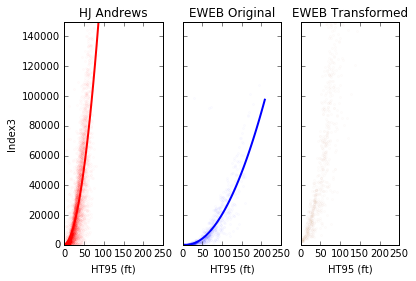

In [21]:
# do some graphing of the transformation for visual inspection
f, ([HJA, EWEB, Quad_trans]) = plt.subplots(1, 3, sharex=True, sharey=True) # a single row of three plots

# sample from arrays for plotting to mitigate long load times in matplotlib
sample = 550 # subsample every X points for graphing from each of the datasets
HJA_x = HJA_HT_flat[0::sample]
HJA_y = HJA_index_flat[0::sample]
EWEB_x = EWEB_HT_flat[0::sample]
EWEB_y = EWEB_index_flat[0::sample]
EWEB_new_index_flat = EWEB_new_index.flatten() # for consistency with other index arrays being graphed
EWEB_trans_y = EWEB_new_index_flat[0::sample]

# arguments for scatter plots, will be unpacked when scatterplot method called
HJA_args = [HJA_x, HJA_y]
EWEB_args = [EWEB_x, EWEB_y]
EWEB_trans_args = [EWEB_x, EWEB_trans_y]

# to plot regression lines, use an array of x values spanning min-max of heights in EWEB and HJA datasets 
xp = np.linspace(min(np.amin(HJA_HT_flat),np.amin(EWEB_HT_flat)),max(np.amax(HJA_HT_flat),np.amax(EWEB_HT_flat)))

# arguments for regression line plots
HJA_regline = [xp, HJA_quad(xp)**2]
EWEB_regline = [xp, EWEB_quad(xp)**2]

# plot scatters
HJA.scatter(*HJA_args, color='red', alpha=0.01, marker='.')
EWEB.scatter(*EWEB_args, color='blue', alpha=0.01, marker ='.')
Quad_trans.scatter(*EWEB_trans_args, color='chocolate', alpha=0.01, marker='.')

# plot regression lines
HJA.plot(*HJA_regline, color='red', linewidth=2)
EWEB.plot(*EWEB_regline, color='blue', linewidth=2)

for ax in [HJA, EWEB, Quad_trans]: 
    # set axis limits for all plots
    ax.set_ylim(bottom=0, top=150000)
    ax.set_xlim(0, 250)
    # label x-axis for all plots
    ax.set_xlabel('HT95 (ft)')

# title each plot
HJA.set_title('HJ Andrews')
EWEB.set_title('EWEB Original')
Quad_trans.set_title('EWEB Transformed')

HJA.set_ylabel('Index3') # put a ylabel on the first plot

plt.show()

In [22]:
# use same mask and other raster settings as EWEB input raster
profile.update(count=1) # but update to have only one band, whereas input raster had two

# output/write the EWEB ALC raster (calculated using transformed Index3 value)
with rasterio.open(os.path.join(EWEB_ALC_path, EWEB_ALC_file), 'w', **profile) as dst:
    dst.write(EWEB_ALC, 1) # array to write to raster and number of bands are the arguments

C:\Anaconda2\lib\site-packages\rasterio\__init__.py:98: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


ValueError: the array's dtype 'float64' does not match the file's dtype 'float32'